In [1]:
%matplotlib notebook
# starter code
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import networkx as nx
from graph_tool.all import load_graph, shortest_distance, GraphView
from networkx.drawing.nx_agraph import graphviz_layout

from cascade import gen_nontrivial_cascade
from utils import get_rank_index

seed = 123456
random.seed(seed)
np.random.seed(seed)

gtype = 'grid'
g = load_graph('data/{}/2-6/graph.gt'.format(gtype))
gnx = nx.read_graphml('data/{}/2-6/graph.graphml'.format(gtype))
gnx = nx.relabel_nodes(gnx, {i: int(i) for i in gnx.nodes_iter()})
N1, N2 = 100, 100
p, q = 0.5, 0.2

pos = graphviz_layout(gnx, root=0)

infection_times, source, obs_nodes, tree = gen_nontrivial_cascade(g, p, q, model='ic', return_tree=True)

In [33]:
from graph_tool import Graph
from graph_tool.search import pbfs_search
from steiner_tree_mst import get_edges
from utils import init_visitor, extract_edges_from_pred

def build_closure(g, terminals,
                  debug=False,
                  verbose=False):
    terminals = list(terminals)
    # build closure
    gc = Graph(directed=False)

    for _ in range(g.num_vertices()):
        gc.add_vertex()

    edges_with_weight = set()
    r2pred = {}

    for r in terminals:
        if debug:
            print('root {}'.format(r))
        vis = init_visitor(g, r)
        pbfs_search(g, source=r, terminals=terminals, visitor=vis)
        new_edges = set(get_edges(vis.dist, r, terminals))
        if debug:
            print('new edges {}'.format(new_edges))
        edges_with_weight |= new_edges
        r2pred[r] = vis.pred
    
    for u, v, c in edges_with_weight:
        gc.add_edge(u, v)
        
    eweight = gc.new_edge_property('int')    
    weights = np.array([c for _, _, c in edges_with_weight])
    eweight.set_2d_array(weights)

    vfilt = gc.new_vertex_property('bool')
    vfilt.a = False
    for v in terminals:
        vfilt[v] = True
    gc.set_vertex_filter(vfilt)
    return gc, eweight, r2pred

In [63]:
def get_steiner_tree(g, obs_nodes, debug=False, verbose=False):
    gc, eweight, r2pred = build_closure(g, obs_nodes,
                                        debug=debug, verbose=verbose)

    tree_map = min_spanning_tree(gc, eweight, root=None)
    tree = GraphView(gc, directed=False, efilt=tree_map)

    tree_edges = set()
    for e in tree.edges():
        u, v = map(int, e)
        for i, j in extract_edges_from_pred(g, u, v, r2pred[u]):
            i, j = sorted([i, j])
            tree_edges.add((i, j))

    t = Graph(directed=False)

    for _ in range(g.num_vertices()):
        t.add_vertex()
    for u, v in tree_edges:
        t.add_edge(u, v)
    tree_nodes = {u for e in tree_edges for u in e}
    vfilt = t.new_vertex_property('bool')
    for v in tree_nodes:
        vfilt[v] = True
    t.set_vertex_filter(vfilt)    
    return t


In [67]:
from graph_tool.topology import min_spanning_tree
from utils import extract_edges_from_pred
from tqdm import tqdm
for i in tqdm(range(100)):
    infection_times, source, obs_nodes, true_tree = gen_nontrivial_cascade(g, p, q, model='ic', return_tree=True)
    pred_tree = get_steiner_tree(g, obs_nodes)
    assert np.all(np.array([v.out_degree() for v in pred_tree.vertices()]) > 0)
    assert np.sum([v.out_degree() for v in pred_tree.vertices()]) == (pred_tree.num_vertices() - 1) * 2
    for o in obs_nodes:
        pred_tree.vertex(o)

100%|██████████| 100/100 [00:09<00:00, 10.05it/s]


<IPython.core.display.Javascript object>


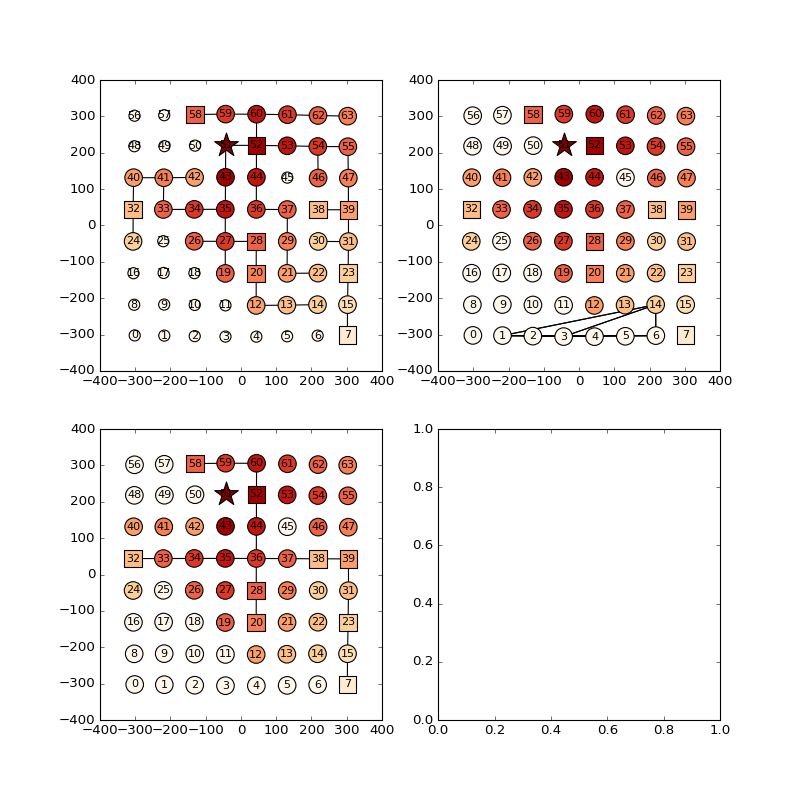

In [68]:
from plot_utils import plot_snapshot
from utils import extract_edges

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 0],
              edges=extract_edges(true_tree))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[0, 1],
              edges=extract_edges(gc))
plot_snapshot(gnx, pos, infection_times, queried_nodes=obs_nodes, source_node=source, with_labels=True,
              ax=ax[1, 0],
              edges=extract_edges(pred_tree))